In [1]:
# Libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report

import shap

# Load merged features
df = pd.read_csv("features_filt.csv")
print(df.shape)
df.head()


(3000, 1544)


,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,admittime,dischtime,...,icd_chapter_M,icd_chapter_N,icd_chapter_Q,icd_chapter_R,icd_chapter_S,icd_chapter_T,icd_chapter_V,icd_chapter_W,icd_chapter_Y,icd_chapter_Z
0,15726459,22744101,30000831,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2140-04-17 21:26:33,2140-04-20 14:21:57,2.705139,2140-04-17 21:25:00,2140-05-18 21:00:00,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,18172623,24751715,30005160,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2130-08-31 23:08:00,2130-09-03 10:33:40,2.476157,2130-08-31 20:39:00,2130-10-08 17:00:00,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
2,19448158,28451027,30008046,Neuro Intermediate,Neuro Intermediate,2154-01-26 17:39:49,2154-01-30 21:17:39,4.151273,2154-01-26 16:20:00,2154-01-30 20:45:00,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,12407894,20375008,30014984,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2127-07-01 07:20:08,2127-07-03 16:15:29,2.371771,2127-07-01 02:04:00,2127-07-14 11:23:00,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,11348907,24524153,30016014,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2110-10-06 18:18:48,2110-10-08 02:00:25,1.320567,2110-10-06 10:23:00,2110-10-16 13:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [2]:
# Convert True/False to 1/0
df['early_readmit'] = df['early_readmit'].astype(int)

# Check the conversion
print(df['early_readmit'].value_counts())



early_readmit
0    2000
1    1000
Name: count, dtype: int64


In [3]:
#print(df.columns.tolist())


In [4]:
# Move target column to the end
target = 'early_readmit'
cols = [c for c in df.columns if c != target] + [target]
df = df[cols]

# Check the new column order
print(df.head())


   subject_id   hadm_id   stay_id  \
0    15726459  22744101  30000831   
1    18172623  24751715  30005160   
2    19448158  28451027  30008046   
3    12407894  20375008  30014984   
4    11348907  24524153  30016014   

                                     first_careunit  \
0                          Coronary Care Unit (CCU)   
1  Medical/Surgical Intensive Care Unit (MICU/SICU)   
2                                Neuro Intermediate   
3               Surgical Intensive Care Unit (SICU)   
4                          Coronary Care Unit (CCU)   

                                      last_careunit               intime  \
0                          Coronary Care Unit (CCU)  2140-04-17 21:26:33   
1  Medical/Surgical Intensive Care Unit (MICU/SICU)  2130-08-31 23:08:00   
2                                Neuro Intermediate  2154-01-26 17:39:49   
3               Surgical Intensive Care Unit (SICU)  2127-07-01 07:20:08   
4                          Coronary Care Unit (CCU)  2110-10-06 18

In [5]:
df = df.drop(['subject_id', 'hadm_id', 'stay_id'], axis=1)
df.head()


,first_careunit,last_careunit,intime,outtime,los,admittime,dischtime,hospital_expire_flag,gender,anchor_age,...,icd_chapter_N,icd_chapter_Q,icd_chapter_R,icd_chapter_S,icd_chapter_T,icd_chapter_V,icd_chapter_W,icd_chapter_Y,icd_chapter_Z,early_readmit
0,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2140-04-17 21:26:33,2140-04-20 14:21:57,2.705139,2140-04-17 21:25:00,2140-05-18 21:00:00,0,M,78,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2130-08-31 23:08:00,2130-09-03 10:33:40,2.476157,2130-08-31 20:39:00,2130-10-08 17:00:00,0,M,57,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0
2,Neuro Intermediate,Neuro Intermediate,2154-01-26 17:39:49,2154-01-30 21:17:39,4.151273,2154-01-26 16:20:00,2154-01-30 20:45:00,0,M,75,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2127-07-01 07:20:08,2127-07-03 16:15:29,2.371771,2127-07-01 02:04:00,2127-07-14 11:23:00,0,M,44,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2110-10-06 18:18:48,2110-10-08 02:00:25,1.320567,2110-10-06 10:23:00,2110-10-16 13:00:00,0,M,76,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1


In [6]:
# Convert datetime columns to pandas datetime
datetime_cols = ['admittime', 'dischtime', 'intime', 'outtime']
for col in datetime_cols:
    df[col] = pd.to_datetime(df[col])

# Create useful numeric features
df['icu_los_hours'] = (df['outtime'] - df['intime']).dt.total_seconds() / 3600
df['hospital_los_hours'] = (df['dischtime'] - df['admittime']).dt.total_seconds() / 3600
df['admit_hour'] = df['admittime'].dt.hour
df['admit_dayofweek'] = df['admittime'].dt.dayofweek
df['icu_admit_hour'] = df['intime'].dt.hour
df['icu_admit_dayofweek'] = df['intime'].dt.dayofweek

# Drop the raw datetime columns
df = df.drop(columns=datetime_cols)

# Print the new columns and first few rows
print(df[['icu_los_hours', 'hospital_los_hours', 'admit_hour', 'admit_dayofweek', 'icu_admit_hour', 'icu_admit_dayofweek']].head())


   icu_los_hours  hospital_los_hours  admit_hour  admit_dayofweek  \
0      64.923333          743.583333          21                6   
1      59.427778          908.350000          20                3   
2      99.630556          100.416667          16                5   
3      56.922500          321.316667           2                1   
4      31.693611          242.616667          10                0   

   icu_admit_hour  icu_admit_dayofweek  
0              21                    6  
1              23                    3  
2              17                    5  
3               7                    1  
4              18                    0  


In [7]:
# Check the DataFrame after creating new numeric features
print(df.head())

# Check all columns
print(df.columns)


                                     first_careunit  \
0                          Coronary Care Unit (CCU)   
1  Medical/Surgical Intensive Care Unit (MICU/SICU)   
2                                Neuro Intermediate   
3               Surgical Intensive Care Unit (SICU)   
4                          Coronary Care Unit (CCU)   

                                      last_careunit       los  \
0                          Coronary Care Unit (CCU)  2.705139   
1  Medical/Surgical Intensive Care Unit (MICU/SICU)  2.476157   
2                                Neuro Intermediate  4.151273   
3               Surgical Intensive Care Unit (SICU)  2.371771   
4                          Coronary Care Unit (CCU)  1.320567   

   hospital_expire_flag gender  anchor_age          next_intime  next_stay_id  \
0                     0      M          78  2140-04-20 22:06:16    36689689.0   
1                     0      M          57  2130-10-26 15:36:00    38598068.0   
2                     0      M     

In [8]:
# Gender: map 'M'->1, 'F'->0
df['gender'] = df['gender'].map({'M':1, 'F':0})
df


,first_careunit,last_careunit,los,hospital_expire_flag,gender,anchor_age,next_intime,next_stay_id,gap_hours,window_end,...,icd_chapter_W,icd_chapter_Y,icd_chapter_Z,early_readmit,icu_los_hours,hospital_los_hours,admit_hour,admit_dayofweek,icu_admit_hour,icu_admit_dayofweek
0,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2.705139,0,1,78,2140-04-20 22:06:16,36689689.0,7.738611,2140-04-20 14:21:57,...,0.0,0.0,1.0,1,64.923333,743.583333,21,6,21,6
1,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2.476157,0,1,57,2130-10-26 15:36:00,38598068.0,1277.038889,2130-09-03 10:33:40,...,0.0,1.0,1.0,0,59.427778,908.350000,20,3,23,3
2,Neuro Intermediate,Neuro Intermediate,4.151273,0,1,75,NaN,NaN,NaN,2154-01-30 21:17:39,...,0.0,0.0,1.0,0,99.630556,100.416667,16,5,17,5
3,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2.371771,0,1,44,2127-07-05 18:00:02,32711047.0,49.742500,2127-07-03 16:15:29,...,0.0,0.0,1.0,1,56.922500,321.316667,2,1,7,1
4,Coronary Care Unit (CCU),Coronary Care Unit (CCU),1.320567,0,1,76,2110-10-08 02:16:49,34159119.0,0.273333,2110-10-08 02:00:25,...,0.0,0.0,0.0,1,31.693611,242.616667,10,0,18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),1.500046,0,1,87,2123-07-04 10:56:30,36389310.0,67.517222,2123-07-01 15:25:28,...,1.0,1.0,1.0,1,36.001111,570.316667,22,4,3,2
2996,Coronary Care Unit (CCU),Coronary Care Unit (CCU),0.373310,0,0,46,2169-02-23 22:38:30,33738626.0,0.008333,2169-02-23 22:38:00,...,0.0,0.0,0.0,1,8.959444,484.666667,13,3,13,3
2997,Neuro Intermediate,Neuro Intermediate,5.088356,0,1,48,NaN,NaN,NaN,2148-03-18 01:56:14,...,0.0,0.0,1.0,0,122.120556,835.233333,22,1,23,1
2998,Neuro Intermediate,Neuro Intermediate,4.191412,0,0,52,NaN,NaN,NaN,2155-12-07 21:40:38,...,0.0,0.0,0.0,0,100.593889,173.816667,16,2,17,2


In [9]:
# One-hot encode first_careunit and last_careunit
df = pd.get_dummies(df, columns=['first_careunit', 'last_careunit'], drop_first=True)
df


,los,hospital_expire_flag,gender,anchor_age,next_intime,next_stay_id,gap_hours,window_end,window_start,discharge_year,...,last_careunit_Medical Intensive Care Unit (MICU),last_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU),last_careunit_Medicine/Cardiology Intermediate,last_careunit_Neuro Intermediate,last_careunit_Neuro Stepdown,last_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU),last_careunit_PACU,last_careunit_Surgery/Vascular/Intermediate,last_careunit_Surgical Intensive Care Unit (SICU),last_careunit_Trauma SICU (TSICU)
0,2.705139,0,1,78,2140-04-20 22:06:16,36689689.0,7.738611,2140-04-20 14:21:57,2140-04-19 14:21:57,2140,...,False,False,False,False,False,False,False,False,False,False
1,2.476157,0,1,57,2130-10-26 15:36:00,38598068.0,1277.038889,2130-09-03 10:33:40,2130-09-02 10:33:40,2130,...,False,True,False,False,False,False,False,False,False,False
2,4.151273,0,1,75,NaN,NaN,NaN,2154-01-30 21:17:39,2154-01-29 21:17:39,2154,...,False,False,False,True,False,False,False,False,False,False
3,2.371771,0,1,44,2127-07-05 18:00:02,32711047.0,49.742500,2127-07-03 16:15:29,2127-07-02 16:15:29,2127,...,False,False,False,False,False,False,False,False,True,False
4,1.320567,0,1,76,2110-10-08 02:16:49,34159119.0,0.273333,2110-10-08 02:00:25,2110-10-07 02:00:25,2110,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1.500046,0,1,87,2123-07-04 10:56:30,36389310.0,67.517222,2123-07-01 15:25:28,2123-06-30 15:25:28,2123,...,False,False,False,False,False,False,False,False,False,False
2996,0.373310,0,0,46,2169-02-23 22:38:30,33738626.0,0.008333,2169-02-23 22:38:00,2169-02-22 22:38:00,2169,...,False,False,False,False,False,False,False,False,False,False
2997,5.088356,0,1,48,NaN,NaN,NaN,2148-03-18 01:56:14,2148-03-17 01:56:14,2148,...,False,False,False,True,False,False,False,False,False,False
2998,4.191412,0,0,52,NaN,NaN,NaN,2155-12-07 21:40:38,2155-12-06 21:40:38,2155,...,False,False,False,True,False,False,False,False,False,False


In [10]:
# Convert all boolean columns to 0/1
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

# Check first few rows
print(df.head())


        los  hospital_expire_flag  gender  anchor_age          next_intime  \
0  2.705139                     0       1          78  2140-04-20 22:06:16   
1  2.476157                     0       1          57  2130-10-26 15:36:00   
2  4.151273                     0       1          75                  NaN   
3  2.371771                     0       1          44  2127-07-05 18:00:02   
4  1.320567                     0       1          76  2110-10-08 02:16:49   

   next_stay_id    gap_hours           window_end         window_start  \
0    36689689.0     7.738611  2140-04-20 14:21:57  2140-04-19 14:21:57   
1    38598068.0  1277.038889  2130-09-03 10:33:40  2130-09-02 10:33:40   
2           NaN          NaN  2154-01-30 21:17:39  2154-01-29 21:17:39   
3    32711047.0    49.742500  2127-07-03 16:15:29  2127-07-02 16:15:29   
4    34159119.0     0.273333  2110-10-08 02:00:25  2110-10-07 02:00:25   

   discharge_year  ...  last_careunit_Medical Intensive Care Unit (MICU)  \
0         

In [11]:
# Drop columns that contain future information
df = df.drop(columns=['next_intime', 'next_stay_id'])

# Check the remaining columns
print(df.columns)


Index(['los', 'hospital_expire_flag', 'gender', 'anchor_age', 'gap_hours',
       'window_end', 'window_start', 'discharge_year', 'label',
       'chart__last__18_gauge_dressing_occlusive_227367',
       ...
       'last_careunit_Medical Intensive Care Unit (MICU)',
       'last_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU)',
       'last_careunit_Medicine/Cardiology Intermediate',
       'last_careunit_Neuro Intermediate', 'last_careunit_Neuro Stepdown',
       'last_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU)',
       'last_careunit_PACU', 'last_careunit_Surgery/Vascular/Intermediate',
       'last_careunit_Surgical Intensive Care Unit (SICU)',
       'last_careunit_Trauma SICU (TSICU)'],
      dtype='object', length=1563)


In [12]:
# Drop columns that contain future information
df = df.drop(columns=['window_start', 'window_end'])

# Check remaining columns
print(df.columns)


Index(['los', 'hospital_expire_flag', 'gender', 'anchor_age', 'gap_hours',
       'discharge_year', 'label',
       'chart__last__18_gauge_dressing_occlusive_227367',
       'chart__last__18_gauge_placed_in_outside_facility_226137',
       'chart__last__18_gauge_placed_in_the_field_228099',
       ...
       'last_careunit_Medical Intensive Care Unit (MICU)',
       'last_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU)',
       'last_careunit_Medicine/Cardiology Intermediate',
       'last_careunit_Neuro Intermediate', 'last_careunit_Neuro Stepdown',
       'last_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU)',
       'last_careunit_PACU', 'last_careunit_Surgery/Vascular/Intermediate',
       'last_careunit_Surgical Intensive Care Unit (SICU)',
       'last_careunit_Trauma SICU (TSICU)'],
      dtype='object', length=1561)


In [13]:
# Move target column to the end
target = 'early_readmit'
cols = [c for c in df.columns if c != target] + [target]
df = df[cols]


In [14]:
# Check first few rows
print(df.head())

        los  hospital_expire_flag  gender  anchor_age    gap_hours  \
0  2.705139                     0       1          78     7.738611   
1  2.476157                     0       1          57  1277.038889   
2  4.151273                     0       1          75          NaN   
3  2.371771                     0       1          44    49.742500   
4  1.320567                     0       1          76     0.273333   

   discharge_year  label  chart__last__18_gauge_dressing_occlusive_227367  \
0            2140      1                                              1.0   
1            2130      0                                              NaN   
2            2154      0                                              NaN   
3            2127      1                                              NaN   
4            2110      1                                              1.0   

   chart__last__18_gauge_placed_in_outside_facility_226137  \
0                                                0.0  

In [15]:
[col for col in df.columns if col.startswith("icd")]
icd_chapter_cols = [col for col in df.columns if "chapter" in col.lower()]
print(icd_chapter_cols)


['icd_chapter_0', 'icd_chapter_1', 'icd_chapter_2', 'icd_chapter_3', 'icd_chapter_4', 'icd_chapter_5', 'icd_chapter_6', 'icd_chapter_7', 'icd_chapter_8', 'icd_chapter_9', 'icd_chapter_A', 'icd_chapter_B', 'icd_chapter_C', 'icd_chapter_D', 'icd_chapter_E', 'icd_chapter_F', 'icd_chapter_G', 'icd_chapter_H', 'icd_chapter_I', 'icd_chapter_J', 'icd_chapter_K', 'icd_chapter_L', 'icd_chapter_M', 'icd_chapter_N', 'icd_chapter_Q', 'icd_chapter_R', 'icd_chapter_S', 'icd_chapter_T', 'icd_chapter_V', 'icd_chapter_W', 'icd_chapter_Y', 'icd_chapter_Z']


In [16]:
icd_individual_cols = [
    col for col in df.columns 
    if col.startswith("icd_") and "chapter" not in col.lower()
]

print(len(icd_individual_cols))
print(icd_individual_cols[:20])


130
['icd_root_041', 'icd_root_070', 'icd_root_244', 'icd_root_250', 'icd_root_272', 'icd_root_274', 'icd_root_276', 'icd_root_278', 'icd_root_280', 'icd_root_285', 'icd_root_287', 'icd_root_288', 'icd_root_296', 'icd_root_300', 'icd_root_303', 'icd_root_305', 'icd_root_311', 'icd_root_327', 'icd_root_338', 'icd_root_345']


In [17]:
icd_chapter_cols = [col for col in df.columns if col.startswith("icd_chapter_")]
print("Number of ICD chapter columns:", len(icd_chapter_cols))


Number of ICD chapter columns: 32


In [18]:
icd_root_cols = [col for col in df.columns if col.startswith("icd_root_")]
print("Number of ICD root columns:", len(icd_root_cols))


Number of ICD root columns: 130


In [19]:
print(icd_chapter_cols)
print(icd_root_cols)


['icd_chapter_0', 'icd_chapter_1', 'icd_chapter_2', 'icd_chapter_3', 'icd_chapter_4', 'icd_chapter_5', 'icd_chapter_6', 'icd_chapter_7', 'icd_chapter_8', 'icd_chapter_9', 'icd_chapter_A', 'icd_chapter_B', 'icd_chapter_C', 'icd_chapter_D', 'icd_chapter_E', 'icd_chapter_F', 'icd_chapter_G', 'icd_chapter_H', 'icd_chapter_I', 'icd_chapter_J', 'icd_chapter_K', 'icd_chapter_L', 'icd_chapter_M', 'icd_chapter_N', 'icd_chapter_Q', 'icd_chapter_R', 'icd_chapter_S', 'icd_chapter_T', 'icd_chapter_V', 'icd_chapter_W', 'icd_chapter_Y', 'icd_chapter_Z']
['icd_root_041', 'icd_root_070', 'icd_root_244', 'icd_root_250', 'icd_root_272', 'icd_root_274', 'icd_root_276', 'icd_root_278', 'icd_root_280', 'icd_root_285', 'icd_root_287', 'icd_root_288', 'icd_root_296', 'icd_root_300', 'icd_root_303', 'icd_root_305', 'icd_root_311', 'icd_root_327', 'icd_root_338', 'icd_root_345', 'icd_root_348', 'icd_root_357', 'icd_root_401', 'icd_root_403', 'icd_root_412', 'icd_root_414', 'icd_root_424', 'icd_root_427', 'icd_r

In [20]:
icd_root_cols = [col for col in df.columns if col.startswith("icd_root_")]
df = df.drop(columns=icd_root_cols)


In [21]:
# After dropping columns

# Remaining ICD chapter columns
icd_chapter_cols_after = [c for c in df.columns if c.startswith("icd_chapter_")]
print("Remaining ICD chapter columns:", len(icd_chapter_cols_after))
print(icd_chapter_cols_after)

# Remaining ICD root columns
icd_root_cols_after = [c for c in df.columns if c.startswith("icd_root_")]
print("Remaining ICD root columns:", len(icd_root_cols_after))
print(icd_root_cols_after)


Remaining ICD chapter columns: 32
['icd_chapter_0', 'icd_chapter_1', 'icd_chapter_2', 'icd_chapter_3', 'icd_chapter_4', 'icd_chapter_5', 'icd_chapter_6', 'icd_chapter_7', 'icd_chapter_8', 'icd_chapter_9', 'icd_chapter_A', 'icd_chapter_B', 'icd_chapter_C', 'icd_chapter_D', 'icd_chapter_E', 'icd_chapter_F', 'icd_chapter_G', 'icd_chapter_H', 'icd_chapter_I', 'icd_chapter_J', 'icd_chapter_K', 'icd_chapter_L', 'icd_chapter_M', 'icd_chapter_N', 'icd_chapter_Q', 'icd_chapter_R', 'icd_chapter_S', 'icd_chapter_T', 'icd_chapter_V', 'icd_chapter_W', 'icd_chapter_Y', 'icd_chapter_Z']
Remaining ICD root columns: 0
[]


In [22]:
# Check first few rows
print(df.head())

        los  hospital_expire_flag  gender  anchor_age    gap_hours  \
0  2.705139                     0       1          78     7.738611   
1  2.476157                     0       1          57  1277.038889   
2  4.151273                     0       1          75          NaN   
3  2.371771                     0       1          44    49.742500   
4  1.320567                     0       1          76     0.273333   

   discharge_year  label  chart__last__18_gauge_dressing_occlusive_227367  \
0            2140      1                                              1.0   
1            2130      0                                              NaN   
2            2154      0                                              NaN   
3            2127      1                                              NaN   
4            2110      1                                              1.0   

   chart__last__18_gauge_placed_in_outside_facility_226137  \
0                                                0.0  

In [23]:
# Check first few rows of the label column
print(df['label'].head())

# Check unique values
print("Unique values in label:", df['label'].unique())

# Check value counts (how many of each class)
print(df['label'].value_counts())


0    1
1    0
2    0
3    1
4    1
Name: label, dtype: int64
Unique values in label: [1 0]
label
0    2000
1    1000
Name: count, dtype: int64


In [24]:
df = df.drop(columns=['label'])
df

,los,hospital_expire_flag,gender,anchor_age,gap_hours,discharge_year,chart__last__18_gauge_dressing_occlusive_227367,chart__last__18_gauge_placed_in_outside_facility_226137,chart__last__18_gauge_placed_in_the_field_228099,chart__last__20_gauge_dressing_occlusive_227368,...,last_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU),last_careunit_Medicine/Cardiology Intermediate,last_careunit_Neuro Intermediate,last_careunit_Neuro Stepdown,last_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU),last_careunit_PACU,last_careunit_Surgery/Vascular/Intermediate,last_careunit_Surgical Intensive Care Unit (SICU),last_careunit_Trauma SICU (TSICU),early_readmit
0,2.705139,0,1,78,7.738611,2140,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
1,2.476157,0,1,57,1277.038889,2130,NaN,NaN,NaN,1.0,...,1,0,0,0,0,0,0,0,0,0
2,4.151273,0,1,75,NaN,2154,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
3,2.371771,0,1,44,49.742500,2127,NaN,NaN,NaN,1.0,...,0,0,0,0,0,0,0,1,0,1
4,1.320567,0,1,76,0.273333,2110,1.0,0.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1.500046,0,1,87,67.517222,2123,NaN,NaN,NaN,1.0,...,0,0,0,0,0,0,0,0,0,1
2996,0.373310,0,0,46,0.008333,2169,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2997,5.088356,0,1,48,NaN,2148,NaN,NaN,NaN,1.0,...,0,0,1,0,0,0,0,0,0,0
2998,4.191412,0,0,52,NaN,2155,NaN,NaN,NaN,1.0,...,0,0,1,0,0,0,0,0,0,0


In [25]:
# Count missing values per column
missing_counts = df.isna().sum()

# Sort columns by missing values in descending order
missing_counts = missing_counts.sort_values(ascending=False)

# Display the top 20 columns with most missing values
print(missing_counts.head(20))


chart__hrs_to_dc__ldh_220632                                          2547
chart__max__ldh_220632                                                2547
chart__min__ldh_220632                                                2547
chart__count__ldh_220632                                              2547
chart__last__ldh_220632                                               2547
chart__trend__ldh_220632                                              2547
chart__mean__ldh_220632                                               2547
lab__abnormal_ct__item_50862_50862                                    2544
lab__last__item_50862_50862                                           2544
lab__hrs_to_dc__item_50862_50862                                      2544
lab__mean__item_50862_50862                                           2544
lab__count__item_50862_50862                                          2544
lab__any_abnormal__item_50862_50862                                   2544
lab__max__item_50862_5086

In [26]:
# Check number of missing values per column
missing_counts = df.isna().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
print(missing_counts)

# Optional: total number of columns with missing values
print(f"Total columns with missing values: {missing_counts.shape[0]}")


chart__last__ldh_220632                2547
chart__max__ldh_220632                 2547
chart__count__ldh_220632               2547
chart__mean__ldh_220632                2547
chart__hrs_to_dc__ldh_220632           2547
                                       ... 
chart__trend__heart_rate_220045           1
chart__hrs_to_dc__heart_rate_220045       1
chart__max__heart_rate_220045             1
chart__last__heart_rate_220045            1
chart__count__heart_rate_220045           1
Length: 1358, dtype: int64
Total columns with missing values: 1358


In [27]:
missing_percent = df.isnull().mean() * 100
cols_to_drop = missing_percent[missing_percent > 60].index
df = df.drop(columns=cols_to_drop)
df

,los,hospital_expire_flag,gender,anchor_age,gap_hours,discharge_year,chart__last__20_gauge_dressing_occlusive_227368,chart__last__20_gauge_placed_in_outside_facility_226138,chart__last__20_gauge_placed_in_the_field_228100,chart__last__activity_mobility_jh_hlm_229321,...,last_careunit_Medical/Surgical Intensive Care Unit (MICU/SICU),last_careunit_Medicine/Cardiology Intermediate,last_careunit_Neuro Intermediate,last_careunit_Neuro Stepdown,last_careunit_Neuro Surgical Intensive Care Unit (Neuro SICU),last_careunit_PACU,last_careunit_Surgery/Vascular/Intermediate,last_careunit_Surgical Intensive Care Unit (SICU),last_careunit_Trauma SICU (TSICU),early_readmit
0,2.705139,0,1,78,7.738611,2140,1.0,1.0,0.0,2.0,...,0,0,0,0,0,0,0,0,0,1
1,2.476157,0,1,57,1277.038889,2130,1.0,0.0,0.0,2.0,...,1,0,0,0,0,0,0,0,0,0
2,4.151273,0,1,75,NaN,2154,NaN,NaN,NaN,2.0,...,0,0,1,0,0,0,0,0,0,0
3,2.371771,0,1,44,49.742500,2127,1.0,0.0,0.0,4.0,...,0,0,0,0,0,0,0,1,0,1
4,1.320567,0,1,76,0.273333,2110,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1.500046,0,1,87,67.517222,2123,1.0,0.0,0.0,2.0,...,0,0,0,0,0,0,0,0,0,1
2996,0.373310,0,0,46,0.008333,2169,0.0,0.0,0.0,NaN,...,0,0,0,0,0,0,0,0,0,1
2997,5.088356,0,1,48,NaN,2148,1.0,0.0,0.0,2.0,...,0,0,1,0,0,0,0,0,0,0
2998,4.191412,0,0,52,NaN,2155,1.0,1.0,0.0,4.0,...,0,0,1,0,0,0,0,0,0,0


In [28]:
# Separate target
X = df.drop(columns=['early_readmit'])  # features
y = df['early_readmit']                 # target
# Now X contains all predictors, y contains the label
print(X.shape, y.shape)

(3000, 867) (3000,)


In [29]:
from sklearn.impute import SimpleImputer

# 1️⃣ Identify numeric columns (int64, float64)
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# 2️⃣ Identify object or boolean columns (categorical)
cat_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()

# 3️⃣ Impute numeric columns with median
num_imputer = SimpleImputer(strategy='median')
X[num_cols] = num_imputer.fit_transform(X[num_cols])

# 4️⃣ Impute categorical/boolean columns with most frequent value (mode)
cat_imputer = SimpleImputer(strategy='most_frequent')
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

# 5️⃣ Check if there are any missing values left
print("Total missing values:", X.isna().sum().sum())


Total missing values: 0


In [30]:
# See first 5 rows
print(X.head())

# See last 5 rows
print(X.tail())

# Or see the full DataFrame (if not too large)
print(X)


        los  hospital_expire_flag  gender  anchor_age    gap_hours  \
0  2.705139                   0.0     1.0        78.0     7.738611   
1  2.476157                   0.0     1.0        57.0  1277.038889   
2  4.151273                   0.0     1.0        75.0    45.441528   
3  2.371771                   0.0     1.0        44.0    49.742500   
4  1.320567                   0.0     1.0        76.0     0.273333   

   discharge_year  chart__last__20_gauge_dressing_occlusive_227368  \
0          2140.0                                              1.0   
1          2130.0                                              1.0   
2          2154.0                                              1.0   
3          2127.0                                              1.0   
4          2110.0                                              1.0   

   chart__last__20_gauge_placed_in_outside_facility_226138  \
0                                                1.0         
1                                 

In [31]:
print("Total missing values:", X.isna().sum().sum())


Total missing values: 0


In [32]:
print(X.describe())


               los  hospital_expire_flag       gender   anchor_age  \
count  3000.000000                3000.0  3000.000000  3000.000000   
mean      3.765621                   0.0     0.573000    62.408333   
std       5.675794                   0.0     0.494725    16.455147   
min       0.250046                   0.0     0.000000    18.000000   
25%       1.123131                   0.0     0.000000    52.750000   
50%       1.982338                   0.0     1.000000    64.000000   
75%       3.902674                   0.0     1.000000    75.000000   
max      75.579236                   0.0     1.000000    91.000000   

           gap_hours  discharge_year  \
count    3000.000000     3000.000000   
mean     1643.798791     2152.342000   
std      7381.153381       23.409536   
min         0.001944     2110.000000   
25%        44.665417     2133.000000   
50%        45.441528     2152.000000   
75%        46.126042     2173.000000   
max    107313.545833     2210.000000   

       c

In [33]:
print(X[cat_cols].describe())


       lab__any_abnormal__item_50868_50868  \
count                                 3000   
unique                                   2   
top                                  False   
freq                                  2543   

       lab__any_abnormal__item_50882_50882  \
count                                 3000   
unique                                   2   
top                                  False   
freq                                  2222   

       lab__any_abnormal__item_50893_50893  \
count                                 3000   
unique                                   2   
top                                  False   
freq                                  1785   

       lab__any_abnormal__item_50902_50902  \
count                                 3000   
unique                                   2   
top                                  False   
freq                                  2176   

       lab__any_abnormal__item_50912_50912  \
count                         

In [34]:
#Drop columns with only one unique value
nunique = X.nunique()
single_value_cols = nunique[nunique == 1].index.tolist()
X = X.drop(columns=single_value_cols)

print(f"Dropped {len(single_value_cols)} single-value columns.")

Dropped 15 single-value columns.


In [35]:
print(X.head())

        los  gender  anchor_age    gap_hours  discharge_year  \
0  2.705139     1.0        78.0     7.738611          2140.0   
1  2.476157     1.0        57.0  1277.038889          2130.0   
2  4.151273     1.0        75.0    45.441528          2154.0   
3  2.371771     1.0        44.0    49.742500          2127.0   
4  1.320567     1.0        76.0     0.273333          2110.0   

   chart__last__20_gauge_dressing_occlusive_227368  \
0                                              1.0   
1                                              1.0   
2                                              1.0   
3                                              1.0   
4                                              1.0   

   chart__last__20_gauge_placed_in_outside_facility_226138  \
0                                                1.0         
1                                                0.0         
2                                                0.0         
3                                         

In [36]:
from sklearn.model_selection import train_test_split

# Assuming X = features, y = target
# Split into train and test (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Check shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (2400, 852)
X_test shape: (600, 852)
y_train shape: (2400,)
y_test shape: (600,)


In [37]:
# Identify numeric columns
num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
print("Numeric columns:", num_cols)


Numeric columns: ['los', 'gender', 'anchor_age', 'gap_hours', 'discharge_year', 'chart__last__20_gauge_dressing_occlusive_227368', 'chart__last__20_gauge_placed_in_outside_facility_226138', 'chart__last__20_gauge_placed_in_the_field_228100', 'chart__last__activity_mobility_jh_hlm_229321', 'chart__last__acuity_workload_question_1_229369', 'chart__last__acuity_workload_question_2_229370', 'chart__last__admission_weight_lbs_226531', 'chart__last__alarms_on_224641', 'chart__last__ambulatory_aid_227343', 'chart__last__anion_gap_227073', 'chart__last__braden_activity_224056', 'chart__last__braden_friction_shear_224059', 'chart__last__braden_mobility_224057', 'chart__last__braden_moisture_224055', 'chart__last__braden_nutrition_224058', 'chart__last__braden_sensory_perception_224054', 'chart__last__bun_225624', 'chart__last__calcium_non_ionized_225625', 'chart__last__cam_icu_ms_change_229326', 'chart__last__chloride_serum_220602', 'chart__last__creatinine_serum_220615', 'chart__last__current_

In [38]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit on training numeric columns and transform both train and test
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Optional: check first few rows
print(X_train.head())
print(X_test.head())


           los    gender  anchor_age  gap_hours  discharge_year  \
388  -0.431366  0.856068    0.212910  -0.222088        1.781644   
71   -0.301610 -1.168132    0.696795  -0.222088        0.802329   
546  -0.355454  0.856068   -0.452433  -0.222631        0.419118   
1135 -0.426658 -1.168132   -1.964575  -0.222088       -0.134407   
815  -0.288254 -1.168132   -0.210490  -0.228163        1.398433   

      chart__last__20_gauge_dressing_occlusive_227368  \
388                                          0.121652   
71                                           0.121652   
546                                          0.121652   
1135                                         0.121652   
815                                          0.121652   

      chart__last__20_gauge_placed_in_outside_facility_226138  \
388                                           -0.289001         
71                                             3.460198         
546                                           -0.289001    

In [49]:
# Convert object columns to numeric
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].map({'True': 1.0, 'False': 0.0})
    X_test[col] = X_test[col].map({'True': 1.0, 'False': 0.0})

# Fill any remaining NaNs with 0.0 (or mean if you prefer)
X_train.fillna(0.0, inplace=True)
X_test.fillna(0.0, inplace=True)


In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix

lr = LogisticRegression(max_iter=1000, class_weight='balanced')   # IMPORTANT
lr_params = {
    'C': [0.01, 0.1, 1, 10]
}

grid_lr = GridSearchCV(
    lr,
    lr_params,
    cv=5,
    scoring='average_precision',   # Better for imbalance
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

best_lr = grid_lr.best_estimator_
y_pred = best_lr.predict(X_test)
y_proba = best_lr.predict_proba(X_test)[:, 1]

print("Best Hyperparameters:", grid_lr.best_params_)
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC:", average_precision_score(y_test, y_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Best Hyperparameters: {'C': 0.01}
ROC-AUC: 0.6743750000000002
PR-AUC: 0.48409944421684453
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.68      0.72       400
           1       0.47      0.58      0.52       200

    accuracy                           0.65       600
   macro avg       0.62      0.63      0.62       600
weighted avg       0.67      0.65      0.65       600

Confusion Matrix:
 [[271 129]
 [ 84 116]]


<Figure size 600x500 with 0 Axes>

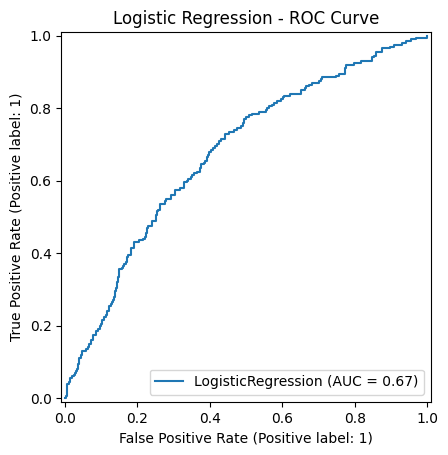

<Figure size 600x500 with 0 Axes>

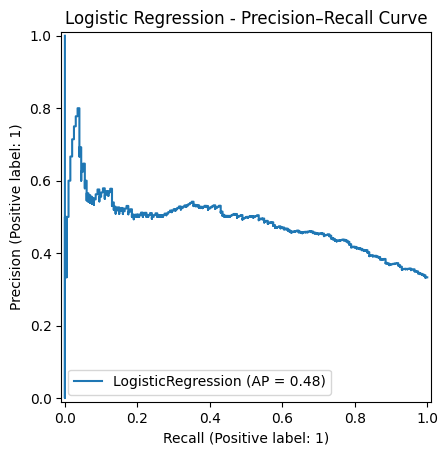

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

# --- ROC Curve ---
plt.figure(figsize=(6,5))
RocCurveDisplay.from_estimator(best_lr, X_test, y_test)
plt.title("Logistic Regression - ROC Curve")
plt.show()

# --- Precision Recall Curve ---
plt.figure(figsize=(6,5))
PrecisionRecallDisplay.from_estimator(best_lr, X_test, y_test)
plt.title("Logistic Regression - Precision–Recall Curve")
plt.show()


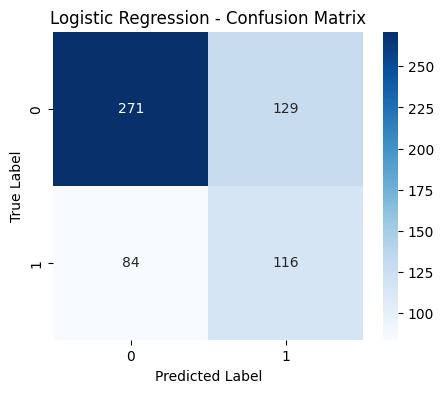

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Logistic Regression - Confusion Matrix')
plt.show()


In [54]:
from sklearn.ensemble import RandomForestClassifier

# Define Random Forest and hyperparameters
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid Search with 5-fold CV
grid_rf = GridSearchCV(rf, rf_params, cv=5, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Best model
best_rf = grid_rf.best_estimator_

# Predictions
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:,1]

# Evaluation
print("=== Random Forest ===")
print("Best Hyperparameters:", grid_rf.best_params_)
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("PR-AUC:", average_precision_score(y_test, y_proba_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


=== Random Forest ===
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
ROC-AUC: 0.9300437500000001
PR-AUC: 0.9119812158774212
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93       400
           1       0.94      0.77      0.85       200

    accuracy                           0.91       600
   macro avg       0.92      0.87      0.89       600
weighted avg       0.91      0.91      0.90       600

Confusion Matrix:
 [[391   9]
 [ 47 153]]


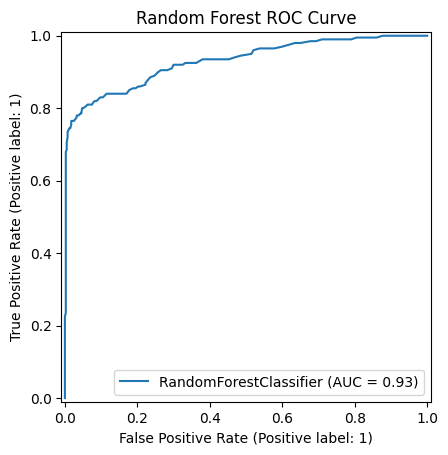

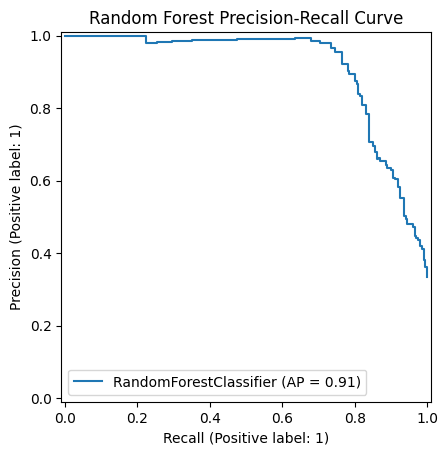

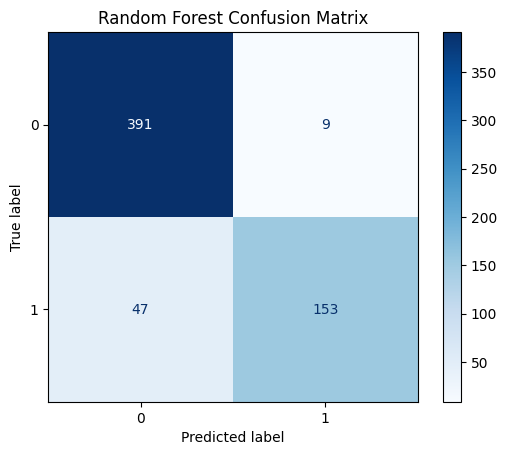

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay

# ---- ROC Curve ----
RocCurveDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("Random Forest ROC Curve")
plt.show()

# ---- Precision-Recall Curve ----
PrecisionRecallDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("Random Forest Precision-Recall Curve")
plt.show()

# ---- Confusion Matrix ----
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, display_labels=[0,1], cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix")
plt.show()


In [57]:
# Convert object columns (True/False or string) to 0/1
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].map({'False': 0, 'True': 1})
    X_test[col] = X_test[col].map({'False': 0, 'True': 1})

# If there are still missing values, fill them with 0
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)


In [59]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define XGBoost
xgb = XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

# Hyperparameter grid
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0]
}

# Create GridSearchCV object
grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_params,
    cv=5,
    scoring='average_precision',
    n_jobs=-1
)

# Fit after defining GridSearchCV
grid_xgb.fit(X_train, y_train)

# Get best model
best_xgb = grid_xgb.best_estimator_
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:,1]

print("=== XGBoost ===")
print("Best Hyperparameters:", grid_xgb.best_params_)
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC:", average_precision_score(y_test, y_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

C:\Users\monic\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:59:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost ===
Best Hyperparameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
ROC-AUC: 1.0
PR-AUC: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       200

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600

Confusion Matrix:
 [[399   1]
 [  0 200]]


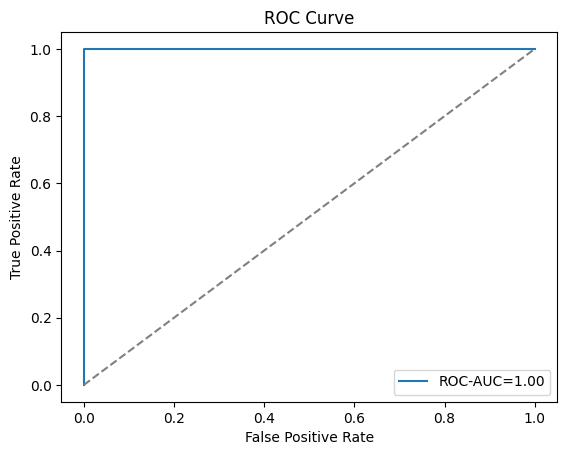

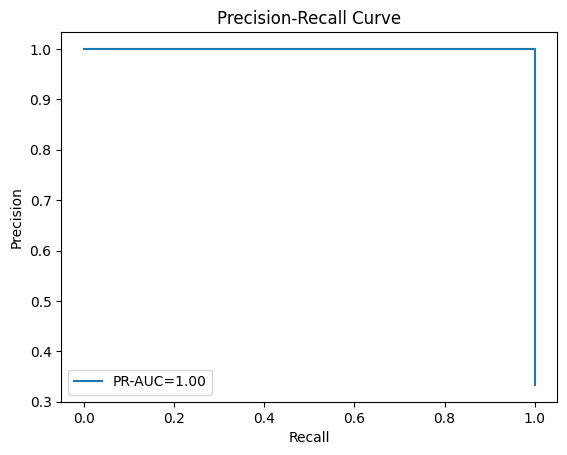

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC-AUC={roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# PR Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(recall, precision, label=f"PR-AUC={average_precision_score(y_test, y_proba):.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


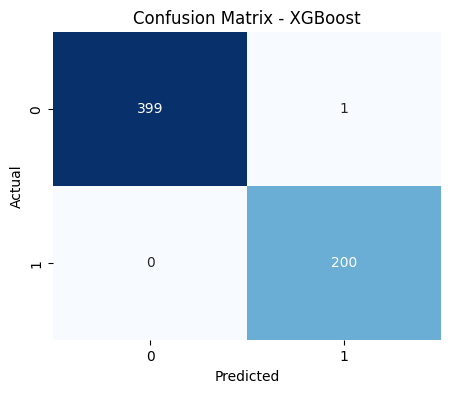

In [63]:

import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot for XGBoost
plot_confusion_matrix(y_test, y_pred, model_name="XGBoost")
